In [1]:
from rich import print

In [2]:
import time

import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import dill as pickle

### Using GPU makes the training process slower than using CPU

Since the dataset is small.

### check if CUDA is available, if yes, set default device to cuda if `using_cusa`

In [3]:
using_cuda = False

if torch.cuda.is_available() and using_cuda:
    print('using CUDA: ', torch.cuda.get_device_name(0))
    torch.set_default_dtype(torch.float32)
    torch.set_default_device('cuda')
    device = torch.device('cuda')
else:
    print('using CPU')
    device = torch.device('cpu')

using CPU

### import Neural Network Class

In [4]:
from neural_network_torch import Classifier

### create neural network

In [5]:
# number of input, hidden and output nodes
input_nodes, hidden_nodes, output_nodes = 784, 200, 10

# learning rate
learning_rate = 0.1

# create instance of neural network
n = Classifier(input_nodes, hidden_nodes, output_nodes, learning_rate, device)

# move neural network to the GPU
if device.type == 'cuda':
    print('Using CUDA')
    n.cuda()

### set training epoch

In [6]:
# epochs is the number of times the training data set is used for training

epochs = 10  # best
# epochs = 1

### load the mnist training data CSV file into a list

In [7]:
with open("./mnist_dataset/mnist_train.csv", 'r') as training_data_file:
    training_data_list = training_data_file.readlines()

### train the neural network

In [8]:
%%time

for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale and shift the inputs
        inputs = (np.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = np.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets, print_counter=True)
        
        # create rotated variations
        # rotated anticlockwise by x degrees
        x = 10
        inputs_plusx_img = scipy.ndimage.rotate(inputs.reshape(28, 28), x, cval=0.01, order=1, reshape=False)
        n.train(inputs_plusx_img.reshape(784), targets, print_counter=True)
        
        # rotated clockwise by x degrees
        inputs_minusx_img = scipy.ndimage.rotate(inputs.reshape(28, 28), -x, cval=0.01, order=1, reshape=False)
        n.train(inputs_minusx_img.reshape(784), targets, print_counter=True)

counter =  10000

counter =  20000

counter =  30000

counter =  40000

counter =  50000

counter =  60000

counter =  70000

counter =  80000

counter =  90000

counter =  100000

counter =  110000

counter =  120000

counter =  130000

counter =  140000

counter =  150000

counter =  160000

counter =  170000

counter =  180000

counter =  190000

counter =  200000

counter =  210000

counter =  220000

counter =  230000

counter =  240000

counter =  250000

counter =  260000

counter =  270000

counter =  280000

counter =  290000

counter =  300000

counter =  310000

counter =  320000

counter =  330000

counter =  340000

counter =  350000

counter =  360000

counter =  370000

counter =  380000

counter =  390000

counter =  400000

counter =  410000

counter =  420000

counter =  430000

counter =  440000

counter =  450000

counter =  460000

counter =  470000

counter =  480000

counter =  490000

counter =  500000

counter =  510000

counter =  520000

counter =  530000

counter =  540000

counter =  550000

counter =  560000

counter =  570000

counter =  580000

counter =  590000

counter =  600000

counter =  610000

counter =  620000

counter =  630000

counter =  640000

counter =  650000

counter =  660000

counter =  670000

counter =  680000

counter =  690000

counter =  700000

counter =  710000

counter =  720000

counter =  730000

counter =  740000

counter =  750000

counter =  760000

counter =  770000

counter =  780000

counter =  790000

counter =  800000

counter =  810000

counter =  820000

counter =  830000

counter =  840000

counter =  850000

counter =  860000

counter =  870000

counter =  880000

counter =  890000

counter =  900000

counter =  910000

counter =  920000

counter =  930000

counter =  940000

counter =  950000

counter =  960000

counter =  970000

counter =  980000

counter =  990000

counter =  1000000

counter =  1010000

counter =  1020000

counter =  1030000

counter =  1040000

counter =  1050000

counter =  1060000

counter =  1070000

counter =  1080000

counter =  1090000

counter =  1100000

counter =  1110000

counter =  1120000

counter =  1130000

counter =  1140000

counter =  1150000

counter =  1160000

counter =  1170000

counter =  1180000

counter =  1190000

counter =  1200000

counter =  1210000

counter =  1220000

counter =  1230000

counter =  1240000

counter =  1250000

counter =  1260000

counter =  1270000

counter =  1280000

counter =  1290000

counter =  1300000

counter =  1310000

counter =  1320000

counter =  1330000

counter =  1340000

counter =  1350000

counter =  1360000

counter =  1370000

counter =  1380000

counter =  1390000

counter =  1400000

counter =  1410000

counter =  1420000

counter =  1430000

counter =  1440000

counter =  1450000

counter =  1460000

counter =  1470000

counter =  1480000

counter =  1490000

counter =  1500000

counter =  1510000

counter =  1520000

counter =  1530000

counter =  1540000

counter =  1550000

counter =  1560000

counter =  1570000

counter =  1580000

counter =  1590000

counter =  1600000

counter =  1610000

counter =  1620000

counter =  1630000

counter =  1640000

counter =  1650000

counter =  1660000

counter =  1670000

counter =  1680000

counter =  1690000

counter =  1700000

counter =  1710000

counter =  1720000

counter =  1730000

counter =  1740000

counter =  1750000

counter =  1760000

counter =  1770000

counter =  1780000

counter =  1790000

counter =  1800000

CPU times: user 6h 15min 11s, sys: 4h 20min 6s, total: 10h 35min 17s
Wall time: 26min 33s


### plot classifier error

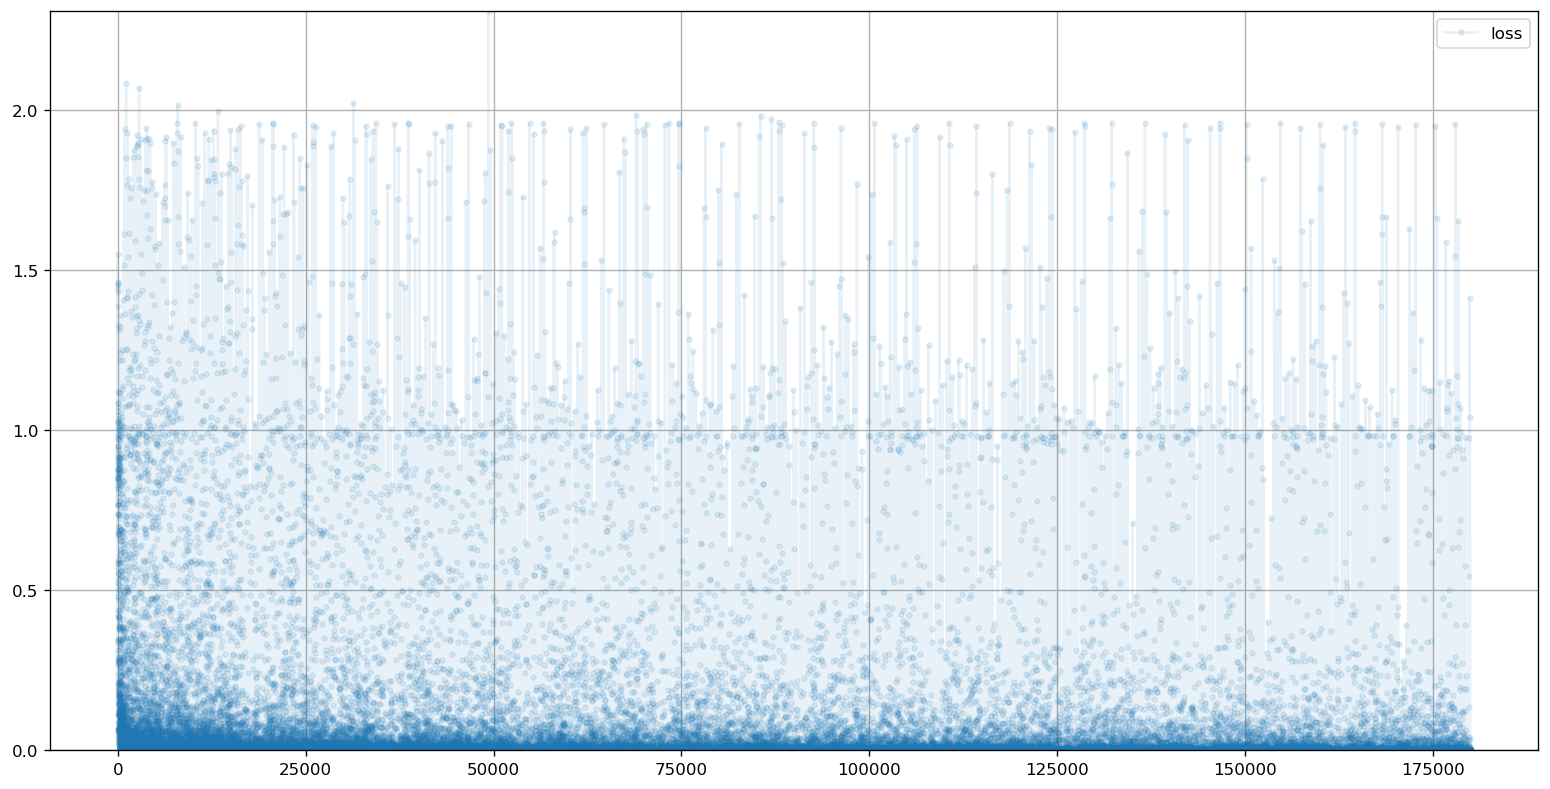

In [9]:
n.plot_progress();

### load the mnist test data CSV file into a list

In [10]:
with open("./mnist_dataset/mnist_test.csv", 'r') as test_data_file:
    test_data_list = test_data_file.readlines()

### test the neural network

In [ ]:
scorecard = []

for record in test_data_list:
    all_values = record.split(',')
    correct_label = int(all_values[0])
    inputs = (np.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    outputs = n.forward(inputs)
    m, label = outputs.max(1)
    
    # append correct or incorrect to list
    if (label.item() == correct_label):
        scorecard.append(1)
    else:
        scorecard.append(0)

# calculate the performance score, the fraction of correct answers
scorecard_array = np.asarray(scorecard, dtype=float)
performance = scorecard_array.sum() / scorecard_array.size
print(f"{performance = :.4f}")

performance = 0.9764

### test backquery

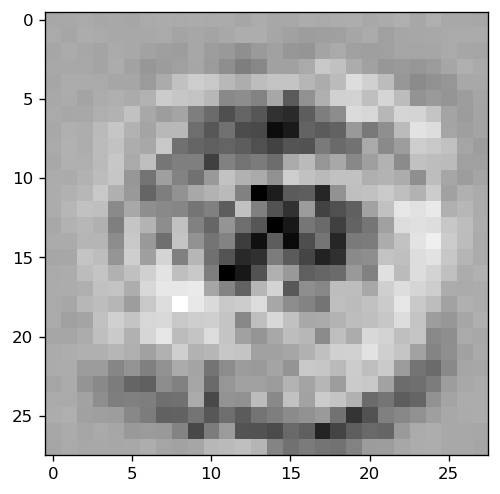

In [12]:
label = 9
targets = np.zeros(output_nodes) + 0.01
targets[label] = 0.99

image_data = n.backquery(targets).cpu().detach().numpy().reshape(28, 28)
plt.imshow(image_data, cmap='Greys', interpolation='None');

In [13]:
print(n)

Classifier(
  (linear_ih): Linear(in_features=784, out_features=200, bias=False)
  (linear_ho): Linear(in_features=200, out_features=10, bias=False)
  (activation): Sigmoid()
  (error_function): MSELoss()
)

In [ ]:
n.epochs = epochs
n.performance = performance
n.trainging_time = " 26 min 33 s"

model_file = f'pytorch_tensor_classifiler_{epochs}.pkl'
# n.pickle(model_file)

torch.save(n, model_file)

/tmp/ipykernel_705193/2004011254.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_n = torch.load(model_file)


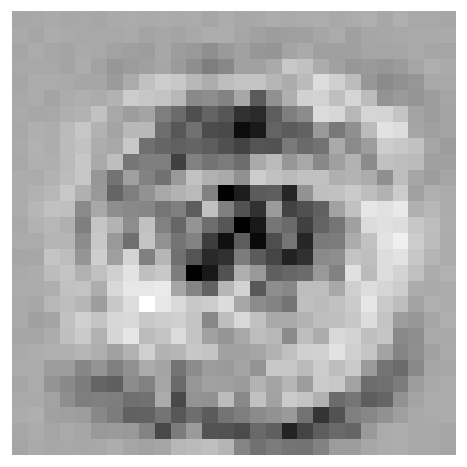

In [18]:
# from pickled object
# with open(model_file, 'rb') as f:
#     new_n = pickle.load(f)
    
new_n = torch.load(model_file)

image_data = new_n.backquery(targets).cpu().detach().numpy().reshape(28, 28)
plt.imshow(image_data, cmap='Greys', interpolation='None')
plt.axis('off');

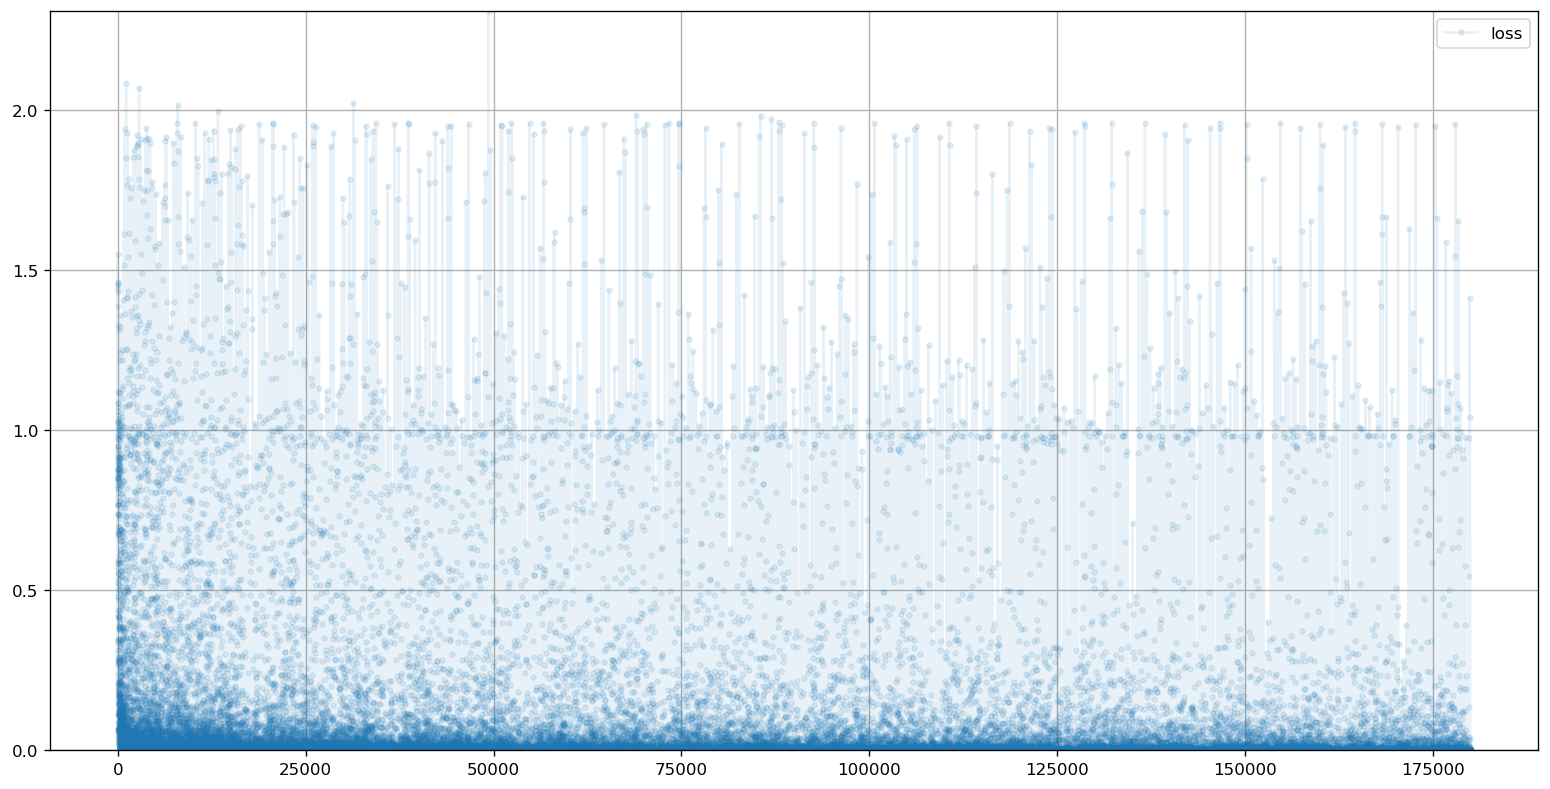

In [19]:
new_n.plot_progress();

### using `torch.save` and `torch.load` to save and load trained model

In [20]:
torch.save(n, 'model.pth')

In [21]:
m = torch.load('model.pth')

/tmp/ipykernel_705193/3633727581.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = torch.load('model.pth')


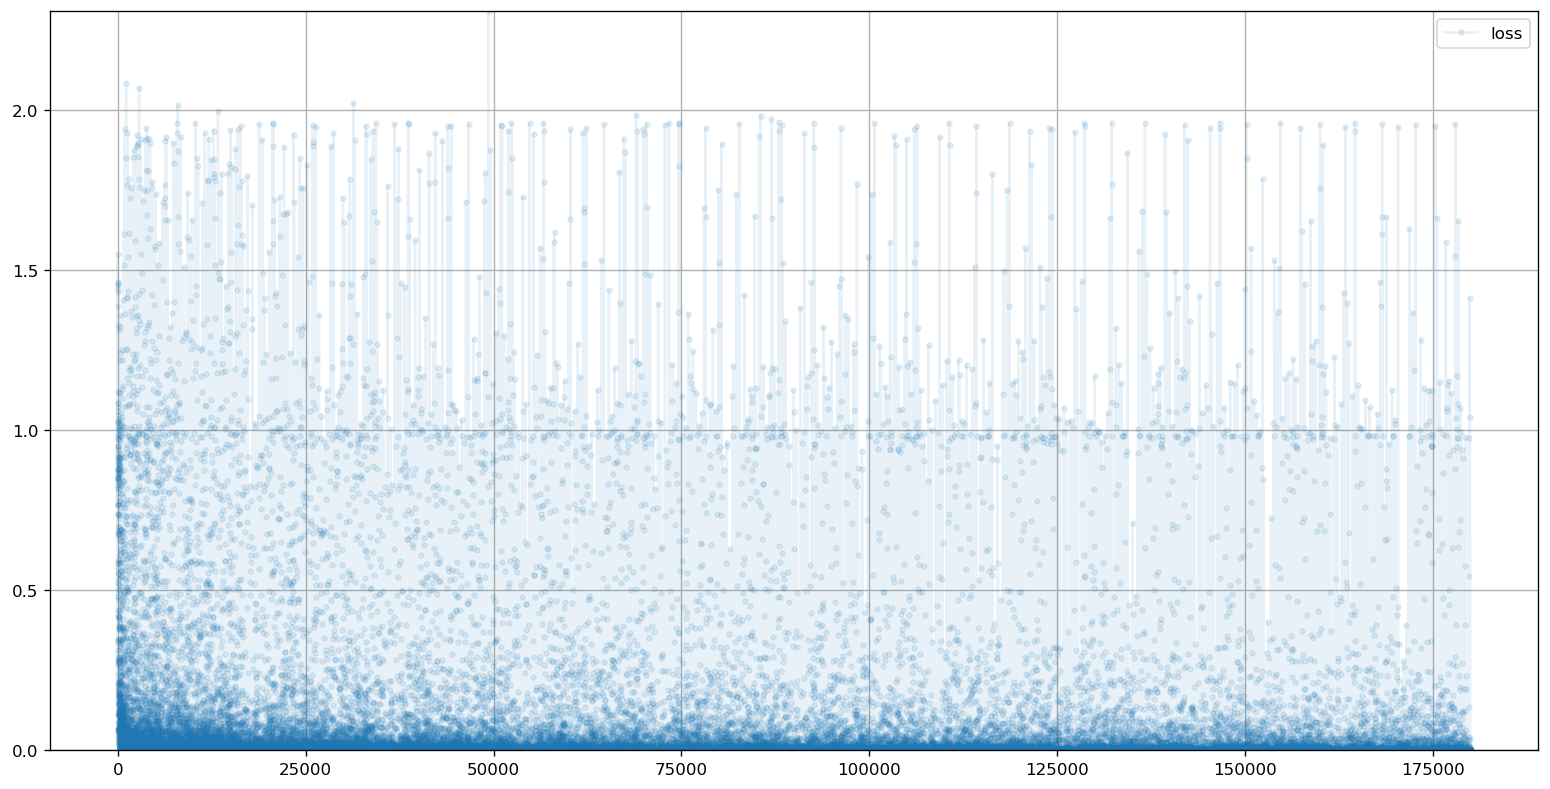

In [22]:
m.plot_progress();